#### Import required libraries

In [98]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     


from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler 
# import plotly.graph_objects as go


# from sklearn.ensemble import IsolationForest  

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
import seaborn as sns #visualisation


In [99]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV  

#### Read the dataset 
- concatnate the data with normal and attack  

In [100]:
# import data set from the local driver 
dff=pd.read_csv('SWaT_Dataset_Normal_v0.csv')#, parse_dates = ['Timestamp'], index_col = 'Timestamp') 
df=pd.read_csv('SWaT_Dataset_Attack_v0 - Copy.csv')#, parse_dates = ['Timestamp'], index_col = 'Timestamp')
frames = [dff,df] 
df_concat=pd.concat(frames) 
df_concat.head(5)    

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


#### Automatic Sensor data extraction 

In [101]:
# # select sensor data 
df1=df_concat.filter(regex='(^Time|^PIT|^AIT|^FIT|^DPI|^LIT|^Norma)',axis=1)#.head()
df1.head()
df1.shape 

(946719, 27)

In [102]:
# remove the space on Normal/Attack columns 
df1['Normal/Attack'] = df1['Normal/Attack'].str.replace(' ', '')  
#To see how the data is spread betwen Attack and Normal 
print(df1.groupby('Normal/Attack')['Normal/Attack'].count())  
# Rename the col name Normal/Attack with A   
df1.rename(columns = {'Normal/Attack':'A'}, inplace = True)
df1.head(2)   

Normal/Attack
Attack     54621
Normal    892098
Name: Normal/Attack, dtype: int64


/tmp/ipykernel_123819/3146584869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Normal/Attack'] = df1['Normal/Attack'].str.replace(' ', '')
/tmp/ipykernel_123819/3146584869.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns = {'Normal/Attack':'A'}, inplace = True)


,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,22/12/2015 4:00:00 PM,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,Normal


In [103]:
# Convert non-numeric to numeric

df1.A[df1.A== 'Normal'] = 0 
df1.A[df1.A == 'Attack'] = 1    
df1.head() 

/tmp/ipykernel_123819/3056417269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A== 'Normal'] = 0
/tmp/ipykernel_123819/3056417269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A== 'Normal'] = 0
/tmp/ipykernel_123819/3056417269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A == 'Attack'] = 1
/tmp/ipykernel_123819/3056417269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,22/12/2015 4:00:00 PM,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
1,22/12/2015 4:00:01 PM,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
2,22/12/2015 4:00:02 PM,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
3,22/12/2015 4:00:03 PM,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
4,22/12/2015 4:00:04 PM,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0


In [104]:
# convert the data type to float 
df1['A'] = df1['A'].astype('float')  

/tmp/ipykernel_123819/406740467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['A'] = df1['A'].astype('float')


In [105]:
# make the Timestamp to datetime datatype 
df1['Timestamp'] = pd.to_datetime(df1['Timestamp']) # conveting the date time stamp to the timestamp series 
df1.head() 
# # df1.shape

#df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])  

#df1.head() 

/tmp/ipykernel_123819/132667980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Timestamp'] = pd.to_datetime(df1['Timestamp']) # conveting the date time stamp to the timestamp series


,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,2015-12-22 16:00:00,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
1,2015-12-22 16:00:01,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2,2015-12-22 16:00:02,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
3,2015-12-22 16:00:03,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
4,2015-12-22 16:00:04,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


In [106]:
# make Timestamp feature  as index 
df1= df1.set_index('Timestamp') 
df1.head()  

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:01,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:02,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:03,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:04,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


##### Interpolation the data with each time stamp

In [107]:
df1=df1.resample('30s').mean()
df1.interpolate(method='polynomial',order=2)
df1.head() 

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.527015,261.350093,244.964963,8.190795,305.947200,2.471492,20.811512,2.234758,327.727143,0.0,...,12.689050,0.001666,0.001409,0.001664,0.0,10.035889,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:30,2.533987,261.661507,246.054433,8.194939,305.670353,2.470548,20.762425,2.233183,328.875350,0.0,...,12.689050,0.001666,0.001409,0.001664,0.0,10.038559,0.0,4.277749,0.000256,0.0
2015-12-22 16:01:00,2.551121,261.970287,247.256037,8.197065,305.438770,2.470001,20.753678,2.232747,329.561600,0.0,...,12.696742,0.001666,0.001409,0.001664,0.0,10.029480,0.0,4.277749,0.000256,0.0
2015-12-22 16:01:30,2.563580,263.051043,248.367950,8.219367,305.002967,2.470872,20.715688,2.232521,331.406750,0.0,...,12.680078,0.001666,0.001409,0.001664,0.0,9.982483,0.0,4.277749,0.000256,0.0
2015-12-22 16:02:00,2.546157,262.971240,249.450997,8.241989,306.291550,2.471564,20.652945,2.232743,333.161107,0.0,...,12.689050,0.001666,0.001409,0.001664,0.0,10.034819,0.0,4.245706,0.000256,0.0


In [108]:
df1.shape 

(117960, 26)

In [109]:
# Count NaN values of whole DataFrame
nan_count = df1.isna().sum()#.sum()
print(nan_count )    

FIT101     86401
LIT101     86401
AIT201     86401
AIT202     86401
AIT203     86401
FIT201     86401
DPIT301    86401
FIT301     86401
LIT301     86401
AIT401     86401
AIT402     86401
FIT401     86401
LIT401     86401
AIT501     86401
AIT502     86401
AIT503     86401
AIT504     86401
FIT501     86401
FIT502     86401
FIT503     86401
FIT504     86401
PIT501     86401
PIT502     86401
PIT503     86401
FIT601     86401
A          86401
dtype: int64


In [110]:
df1.fillna(method = 'ffill', inplace = True)    

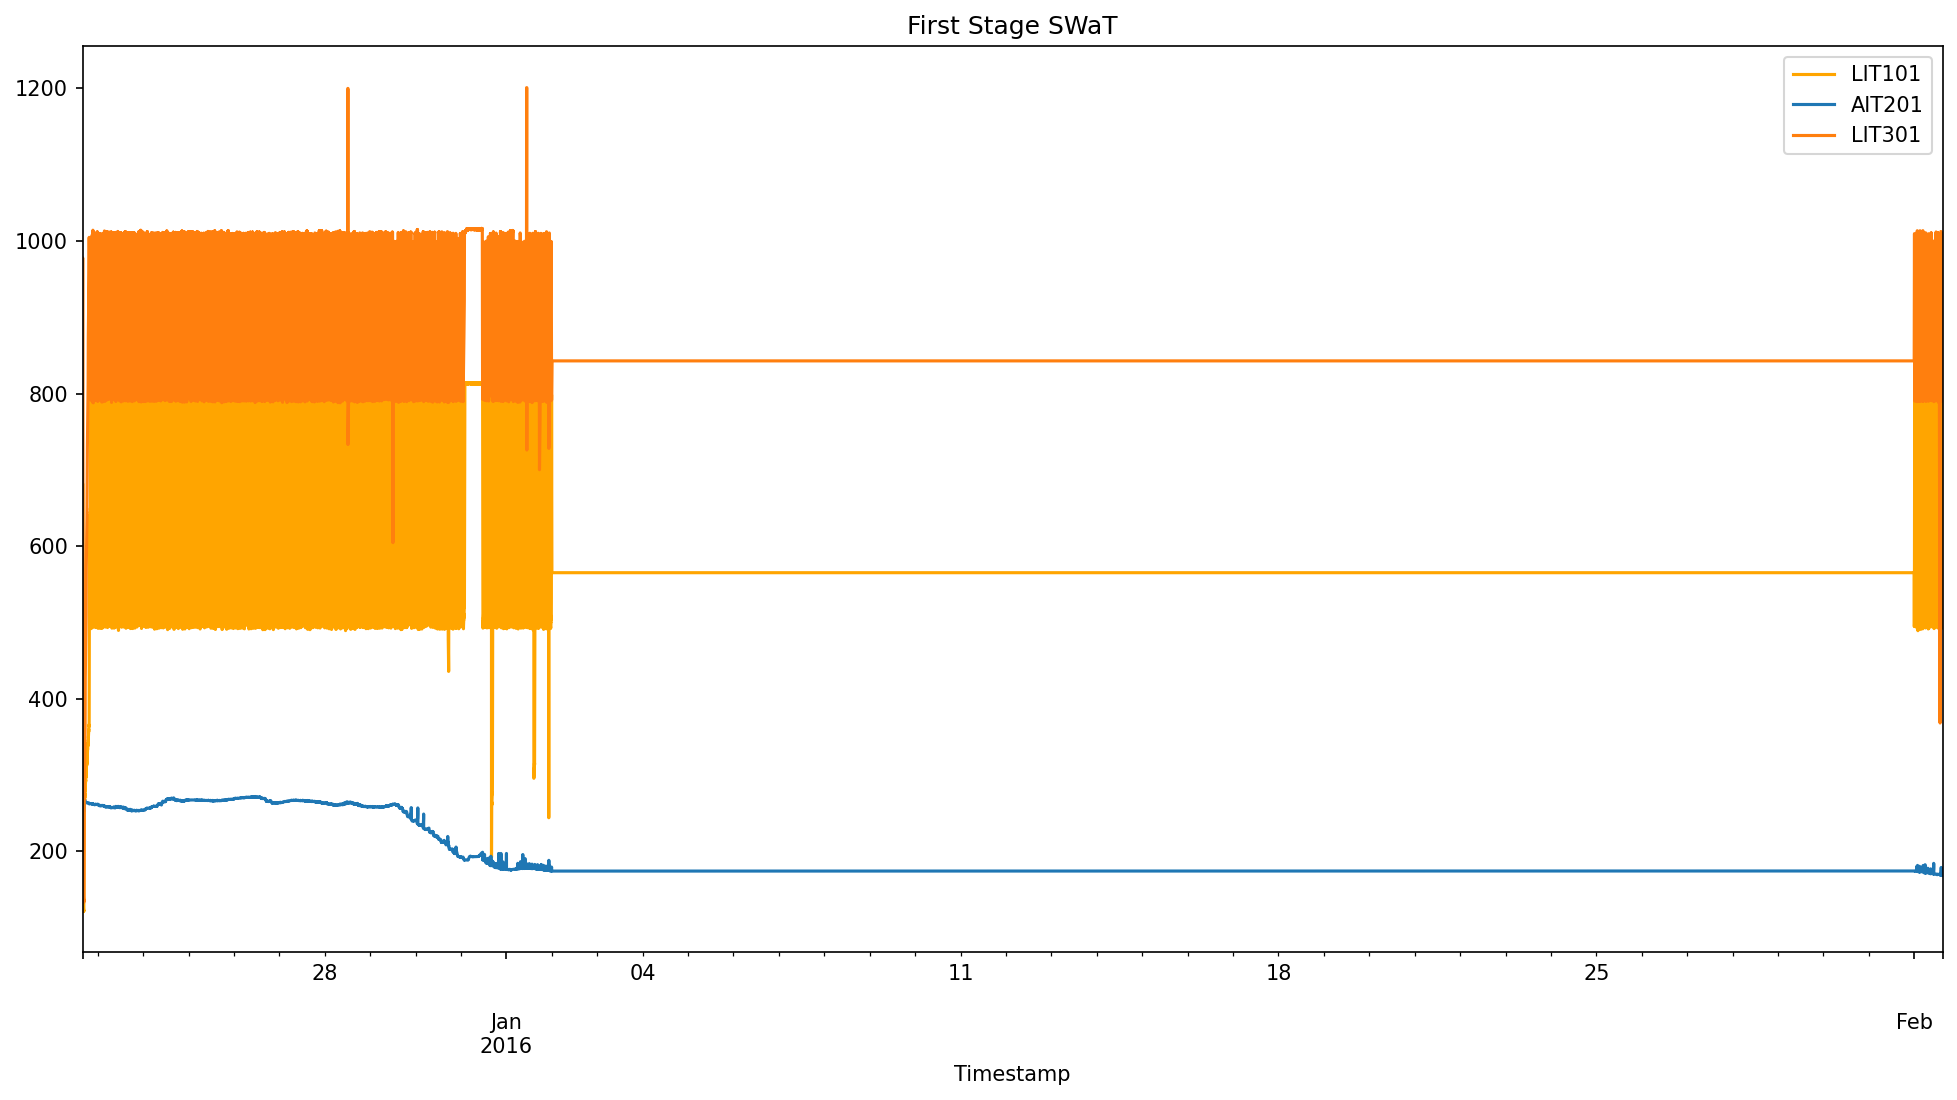

In [63]:
# code
# Visualizing The first stage with respect to time series 
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.

df1['LIT101'].plot(label='LIT101', color='orange')
df1['AIT201'].plot(label='AIT201')

df1['LIT301'].plot(label='LIT301')

# adding title to the plot
plt.title('First Stage SWaT')
# adding Label to the x-axis
plt.xlabel('Timestamp')  
# adding legend to the curve
plt.legend()   

In [111]:
# make the class label into 2 since during sampling and interpolation it create the new class labels
df1.loc[df1['A'] >= 0.2, 'lablel'] = 1 
df1.loc[df1['A'] ==0.0, 'lablel'] = 0 

In [112]:
# fill the missing values with forward and backward of the cols 

df1=df1.fillna(method="ffill") 

In [113]:
df1.isna().sum() 

FIT101     0
LIT101     0
AIT201     0
AIT202     0
AIT203     0
FIT201     0
DPIT301    0
FIT301     0
LIT301     0
AIT401     0
AIT402     0
FIT401     0
LIT401     0
AIT501     0
AIT502     0
AIT503     0
AIT504     0
FIT501     0
FIT502     0
FIT503     0
FIT504     0
PIT501     0
PIT502     0
PIT503     0
FIT601     0
A          0
lablel     0
dtype: int64

#### Visualize the dataset 
-  Plotting the number of normal and Attack transactions in the dataset. 

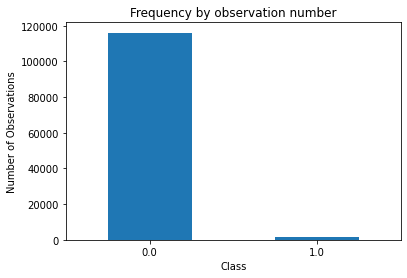

In [114]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(df1['lablel'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(df1['lablel'].unique())))#, df1.A.unique()))
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");    

In [115]:
df1= df1.drop('A', axis=1) 

In [116]:
# count the number of anomalies and normal data points in our dataset 
df1['lablel'].value_counts() 
 

0.0    116111
1.0      1849
Name: lablel, dtype: int64

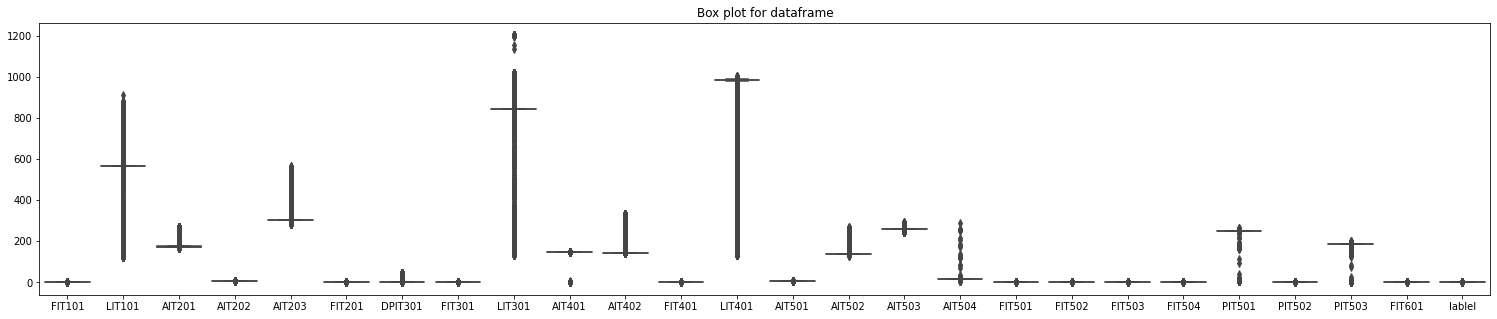

In [70]:
# checking the outlier in the data 
# sns.boxplot(data=df) 
fig = plt.figure(figsize=(26,5))
sns.boxplot(data=df1)  
# plt.xticks([1,2],['Our data', 'Hypothetical data'])
# plt.ylabel('Grade')
plt.title('Box plot for dataframe')
plt.show()   

### Normalize using Min max Scaler  

In [117]:
# # For content length, use the Min max Scalar.  
# from sklearn.preprocessing import MinMaxScaler 

con_feats = ['FIT101','LIT101','AIT201','AIT202','AIT203','FIT201','DPIT301','FIT301','FIT301','LIT301','AIT401',
            'AIT402','FIT401','LIT401','AIT501','AIT502','AIT503','AIT504','FIT501','FIT502','FIT503','FIT504',
            'PIT501','PIT502','PIT503','FIT601'] 
scaler = MinMaxScaler() 
df1[con_feats] = scaler.fit_transform(df1[con_feats])
df1.head(5) 

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,0.973730,0.177197,0.741168,0.734494,0.072905,0.875494,0.462307,0.973430,0.182210,0.0,...,0.018253,0.000711,0.000608,0.002186,0.0,0.004475,0.0,0.005924,0.000151,0.0
2015-12-22 16:00:30,0.976416,0.177591,0.751668,0.735883,0.071920,0.875159,0.461216,0.972744,0.183285,0.0,...,0.018253,0.000711,0.000608,0.002186,0.0,0.004485,0.0,0.005924,0.000151,0.0
2015-12-22 16:01:00,0.983019,0.177982,0.763248,0.736596,0.071097,0.874966,0.461022,0.972554,0.183928,0.0,...,0.018281,0.000711,0.000608,0.002186,0.0,0.004450,0.0,0.005924,0.000151,0.0
2015-12-22 16:01:30,0.987819,0.179349,0.773965,0.744073,0.069547,0.875274,0.460177,0.972456,0.185656,0.0,...,0.018222,0.000711,0.000608,0.002186,0.0,0.004266,0.0,0.005924,0.000151,0.0
2015-12-22 16:02:00,0.981106,0.179248,0.784403,0.751657,0.074129,0.875519,0.458782,0.972552,0.187299,0.0,...,0.018253,0.000711,0.000608,0.002186,0.0,0.004471,0.0,0.005762,0.000151,0.0


In [118]:
df1.shape 

(117960, 26)

#### Split the Data to train and Test 

In [119]:
# split the normal data with respect to test and Train 
from sklearn.model_selection import train_test_split 
x_good_train, x_good_test = train_test_split(df1, test_size=0.2, random_state=42)   

In [120]:
print(x_good_train.shape)
print(x_good_test.shape) 

(94368, 26)
(23592, 26)


In [121]:
# Training and testing with removing the class 
x_good_train = x_good_train[x_good_train.lablel == 0.0] #where normal transactions 
x_good_train = x_good_train.drop(['lablel'], axis=1) #drop the class columns 

test_y = x_good_test['lablel'] # save the class column for the test set 
x_good_test = x_good_test.drop(['lablel'], axis=1) #drop the class column 

x_good_train = x_good_train.values #transform to ndarray 
x_good_test = x_good_test.values 
x_good_train.shape, x_good_test.shape #,x_good_train.shape,test_y.shape     

((92878, 25), (23592, 25))

#### Build Model 

In [122]:
######### 
#Define the autoencoder model
#Since we're dealing with numeric values we can use only Dense layers.

from sklearn import metrics
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense  
from keras.layers import Input, Dense
from keras import regularizers 
from keras.models import Model, load_model 
import datetime  

In [123]:
#TIME_STEPS = 288 
model = Sequential()
# encoder 
model.add(Dense(128, input_dim=x_good_train.shape[1], activation='relu')) # Input layers or encoder sigmoid relu
Dropout(0.01), 
model.add(Dense(32, activation='relu')) ## 
Dropout(0.01), 
model.add(Dense(32, activation='relu')) ## 
Dropout(0.01), 

model.add(Dense(128, activation='relu')) ## decoder 
Dropout(0.1), 
model.add(Dense(x_good_train.shape[1])) # output layers 
model.compile(loss='msle',metrics=['accuracy'],optimizer='adam')  
model.summary()  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               3328      
                                                                 
 dense_11 (Dense)            (None, 32)                4128      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 128)               4224      
                                                                 
 dense_14 (Dense)            (None, 25)                3225      
                                                                 
Total params: 15,961
Trainable params: 15,961
Non-trainable params: 0
_________________________________________________________________


#### Train the model

- Please note that we are using x_good_test as both the input and the target since this is a reconstruction model.


In [124]:
#model.fit(x_good_train,x_good_train,verbose=1,epochs=100) 
grid=model.fit(
    x_good_train,x_good_train,
    verbose=2,
    epochs=10,
    batch_size=512,
    validation_data=(x_good_test, x_good_test), 
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])  
score=model.evaluate(x_good_test, x_good_test, verbose=1)
print('Test loss:', score[0]) 
print('accuracy:', score[1])  

Epoch 1/10
182/182 - 2s - loss: 0.0573 - accuracy: 0.0018 - val_loss: 0.0411 - val_accuracy: 0.0045 - 2s/epoch - 9ms/step
Epoch 2/10
182/182 - 1s - loss: 0.0380 - accuracy: 0.0032 - val_loss: 0.0371 - val_accuracy: 0.0058 - 1s/epoch - 6ms/step
Epoch 3/10
182/182 - 1s - loss: 0.0365 - accuracy: 0.0063 - val_loss: 0.0369 - val_accuracy: 0.0064 - 1s/epoch - 6ms/step
Epoch 4/10
182/182 - 1s - loss: 0.0364 - accuracy: 0.0061 - val_loss: 0.0368 - val_accuracy: 0.0048 - 1s/epoch - 6ms/step
Epoch 5/10
182/182 - 1s - loss: 0.0364 - accuracy: 0.0061 - val_loss: 0.0367 - val_accuracy: 0.0064 - 1s/epoch - 6ms/step
Epoch 6/10
182/182 - 1s - loss: 0.0363 - accuracy: 0.0074 - val_loss: 0.0367 - val_accuracy: 0.0071 - 1s/epoch - 6ms/step
Epoch 7/10
182/182 - 1s - loss: 0.0363 - accuracy: 0.0079 - val_loss: 0.0366 - val_accuracy: 0.0102 - 1s/epoch - 6ms/step
Epoch 8/10
182/182 - 1s - loss: 0.0363 - accuracy: 0.0094 - val_loss: 0.0366 - val_accuracy: 0.0097 - 1s/epoch - 6ms/step
Epoch 9/10
182/182 - 1s 

#### Plot training and test loss 

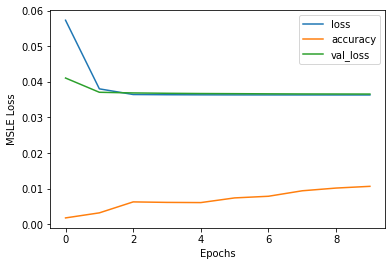

In [125]:
plt.plot(grid.history['loss'])
plt.plot(grid.history['accuracy'])
plt.plot(grid.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss','accuracy', 'val_loss'])
plt.show()  

### Detect Anomalies on test data  
- Anomalies are data points where the reconstruction loss is higher 
- To calculate the reconstruction loss on test data, predict the test data and calculate the mean square error between the test data and the reconstructed test data. 

#### Predictions and Computing Reconstruction Error

In [126]:
test_x_predictions = model.predict(x_good_test)#,verbose=1)
mse = np.mean(np.power(x_good_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,'A': test_y}, index=test_y.index)  
error_df.head() 

,Reconstruction_error,A
Timestamp,,
2016-01-30 10:34:30,0.245947,0.0
2016-01-22 03:14:30,0.245947,0.0
2016-01-12 00:56:30,0.245947,0.0
2016-01-07 16:57:00,0.245947,0.0
2016-01-18 00:51:30,0.245947,0.0


In [127]:
# find the maximum of each column using reconstruction error 
maxValues = error_df.max()
 
print(maxValues)  

Reconstruction_error    0.489395
A                       1.000000
dtype: float64


In [128]:
# finding the number of anomalies using highest reconstruction Error 

outliers = error_df.index[error_df.Reconstruction_error >0.48].tolist()  
number_of_outliers = len(outliers) 
print("Number of elements in the anomalies: ", number_of_outliers)  

Number of elements in the anomalies:  3


In [129]:
# To identify the maximum and minimum data point for identifying bins 
import tensorflow as tf 
# reconstruction loss for normal test data
#reconstructions = model.predict(normal_test_data)
train_loss1 = tf.keras.losses.mae(test_x_predictions, x_good_test)


trainloss1=pd.DataFrame(train_loss1)
#trainloss.describe()
#trainloss.to_csv(r'/home/jovyan/trainloss.csv',index=False) 
trainloss1.describe()  

,0
count,23592.000000
mean,0.210824
std,0.033881
min,0.115439
25%,0.191289
50%,0.191289
75%,0.233334
max,0.443623


Text(0.5, 1.0, 'bins - loss distribution = 15')

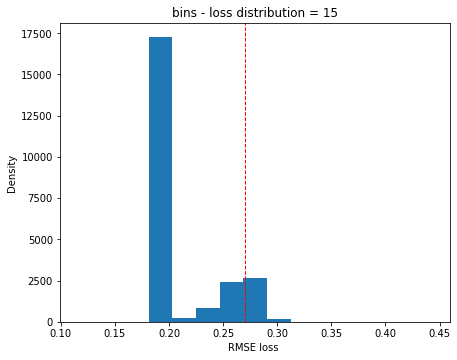

In [138]:
# rules-of-thumb to identify the number of bins Freedman–Diaconis rule 
trainloss1=pd.DataFrame(trainloss1) 
q1 = trainloss1.quantile(0)
q3 = trainloss1.quantile(1)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(trainloss1) ** (1 / 3))
bin_count = int(np.ceil((trainloss1.max() - trainloss1.min()) / bin_width))
fig = plt.figure(figsize=(7,5.5))
plt.hist(train_loss1, bins = bin_count)  
#sns.histplot(x=trainloss,bins=bin_count)
plt.axvline(0.27,0, 9000,color='red', linestyle='dashed', linewidth=1) 
plt.xlabel('RMSE loss ')
plt.ylabel('Density')
plt.title(f'bins - loss distribution = {bin_count}')  

### Model Interpretability 

In [131]:
# change X_tes_scaled to pandas dataframe
data_n = pd.DataFrame(x_good_test, index= test_y.index)#, columns=numerical_cols)  

In [132]:
def compute_error_per_dim(point):
    
    initial_pt = np.array(data_n.loc[point,:]).reshape(1,9)
    reconstrcuted_pt = model.predict(initial_pt)
    
    return abs(np.array(initial_pt - reconstrcuted_pt)[0])  

In [134]:
outliers = error_df.index[error_df.Reconstruction_error > 0.27].tolist()  
number_of_outliers = len(outliers) 
print("Number of elements in the anomalies: ", number_of_outliers)   

Number of elements in the anomalies:  5937


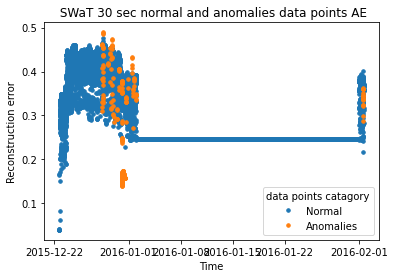

In [135]:
from matplotlib.colors import ListedColormap 
#plt.figure(figsize=(18,10))
threshold_fixed = 0.27
groups = error_df.groupby('A')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomalies" if name == 1 else "Normal")
#ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(title='data points catagory')
plt.title(" SWaT 30 sec normal and anomalies data points AE")
plt.ylabel("Reconstruction error")
plt.xlabel("Time") 
#plt.show();   
plt.savefig('SWaT_AE_30sed.png')  

#### Calculate RMSE and MAE  

In [136]:
# Define a function to calculate MAE and RMSE
errors = test_x_predictions - x_good_test
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()

print('The performance  of autoencoder'+ ':') 
print('')
print('Mean Absolute Error: {:.4f}'.format(mae)) 
print('Mean Square Error:{:.4f}' .format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('')   

The performance  of autoencoder:

Mean Absolute Error: 0.2108
Mean Square Error:0.2800
Root Mean Square Error: 0.5292



#### Precision and Recall 

In [137]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score 
threshold_fixed = 0.27
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.A, pred_y)
plt.figure(figsize=(4, 4))

print(conf_matrix)
# sns.heatmap(conf_matrix, xticklabels=df1.A, yticklabels=df1.A, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show() 
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['A'], error_df['pred']))
# print(" Recall: ",recall_score(error_df['A'], error_df['pred']))
# print(" Precision: ",precision_score(error_df['A'], error_df['pred'])) 
print(classification_report(error_df['A'], error_df['pred']))  

[[17439  5794]
 [  216   143]]
 Accuracy:  0.7452526280094948
              precision    recall  f1-score   support

         0.0       0.99      0.75      0.85     23233
         1.0       0.02      0.40      0.05       359

    accuracy                           0.75     23592
   macro avg       0.51      0.57      0.45     23592
weighted avg       0.97      0.75      0.84     23592



<Figure size 288x288 with 0 Axes>

#### Mean p-Powered Error 
- To enhance the perfomance of reall and precision 

In [44]:
test_x_predictions = model.predict(x_good_test)#,verbose=1)
mse = np.mean(np.power(x_good_test - test_x_predictions, 4), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,'A': test_y}, index=test_y.index)  
error_df.head()  

,Reconstruction_error,A
Timestamp,,
2016-01-30 10:34:30,0.159074,0.0
2016-01-22 03:14:30,0.159074,0.0
2016-01-12 00:56:30,0.159074,0.0
2016-01-07 16:57:00,0.159074,0.0
2016-01-18 00:51:30,0.159074,0.0


In [45]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score 
threshold_fixed = 0.16
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.A, pred_y)
plt.figure(figsize=(4, 4))

print(conf_matrix)
# sns.heatmap(conf_matrix, xticklabels=df1.A, yticklabels=df1.A, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show() 



# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['A'], error_df['pred']))
print(" Recall: ",recall_score(error_df['A'], error_df['pred']))
print(" Precision: ",precision_score(error_df['A'], error_df['pred']))  

[[17360  5873]
 [  221   138]]
 Accuracy:  0.7416920990166158
 Recall:  0.38440111420612816
 Precision:  0.022957910497421394


<Figure size 288x288 with 0 Axes>

### Model bulding using Isolation forest 

#### Split the Data to train and Test 

In [48]:
df1.shape

(117960, 26)

In [49]:
# Train test split (80/20 %) 
X_train, X_test, y_train, y_test = train_test_split(df1,df1['lablel'],test_size=0.2, random_state=42)
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
  

The number of records in the training dataset is 94368
The number of records in the test dataset is 23592


In [50]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)  

(94368, 26)
(23592, 26)
(94368,)
(23592,)


#### Hyperparameter tuning for 30 second logs using Isolation forest  

In [60]:
from sklearn import model_selection 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer, f1_score 
clf = IsolationForest(random_state=47)

param_grid = {'n_estimators': [5,10,20,30,40],#list(range(100, 800)),#, 5)), 
              'max_samples': [5,10,20,30,40], #list(range(100, 500)),#, 5)), 
              'contamination': [0.1, 0.2, 0.3, 0.4],# 0.5], 
              'max_features': [5,10,15], 
              #'bootstrap': [True, False], 
              #'n_jobs': [5, 10, 20, 30]
             }

f1sc = make_scorer(f1_score, average='micro')

grid_search = model_selection.GridSearchCV(clf, 
                                                 param_grid,                                                  
                                                 refit=True,
                                                 scoring=f1sc,
                                                 cv=10, 
                                                 return_train_score=True)
#grid_dt_estimator.fit(X_train, X_test)

best_model = grid_search.fit(X_train.values, y_train) 

print('Optimum parameters', best_model.best_params_)     

Optimum parameters {'contamination': 0.1, 'max_features': 10, 'max_samples': 10, 'n_estimators': 5}


#### Train Isolation Forest Model  

In [51]:
# Model and performance
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report  

In [52]:
# Train the isolation forest model
if_model = IsolationForest(n_estimators=10,max_samples=15,contamination=0.1,random_state=47).fit(X_train)
# Predict the anomalies
if_prediction = if_model.predict(X_test)
# Change the anomalies' values to make it consistent with the true values
if_prediction = [1 if i==-1 else 0 for i in if_prediction]
 

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


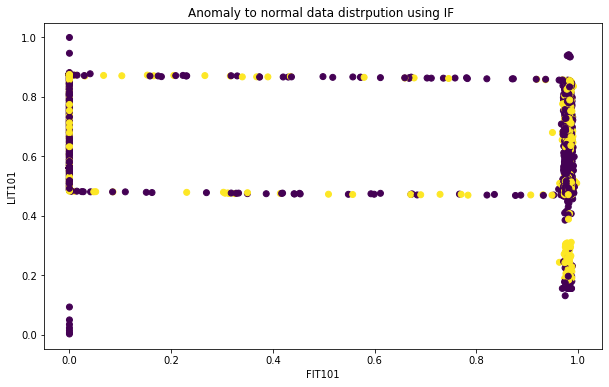

In [53]:
# visualize the anomaly points in the dataset with 2D
plt.figure(figsize=(10,6)) 
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=if_prediction)
plt.title("Anomaly to normal data distrpution using IF ")
plt.xlabel("FIT101")
plt.ylabel("LIT101")
plt.show()  

#### determine anomaly score and identify anomalies

In [54]:
result = X_test.copy()
result['scores'] = if_model.decision_function(X_test)
result['anomaly'] = if_model.predict(X_test)
result['anomaly'] = result['anomaly'].map( {1: 0, -1: 1} )
print(result['anomaly'].value_counts()) 

0    21229
1     2363
Name: anomaly, dtype: int64


In [55]:
result.head()  

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel,scores,anomaly
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-30 10:34:30,0.0,0.561579,0.057482,0.875637,0.062914,0.871924,0.042303,0.0,0.664595,0.999935,...,0.976835,0.959754,0.966992,0.939598,0.281933,0.933113,0.0,0.0,0.262699,0
2016-01-22 03:14:30,0.0,0.561579,0.057482,0.875637,0.062914,0.871924,0.042303,0.0,0.664595,0.999935,...,0.976835,0.959754,0.966992,0.939598,0.281933,0.933113,0.0,0.0,0.262699,0
2016-01-12 00:56:30,0.0,0.561579,0.057482,0.875637,0.062914,0.871924,0.042303,0.0,0.664595,0.999935,...,0.976835,0.959754,0.966992,0.939598,0.281933,0.933113,0.0,0.0,0.262699,0
2016-01-07 16:57:00,0.0,0.561579,0.057482,0.875637,0.062914,0.871924,0.042303,0.0,0.664595,0.999935,...,0.976835,0.959754,0.966992,0.939598,0.281933,0.933113,0.0,0.0,0.262699,0
2016-01-18 00:51:30,0.0,0.561579,0.057482,0.875637,0.062914,0.871924,0.042303,0.0,0.664595,0.999935,...,0.976835,0.959754,0.966992,0.939598,0.281933,0.933113,0.0,0.0,0.262699,0


In [56]:
anomaly = result.loc[result['anomaly'] == 1]
anomaly.head(5)  

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel,scores,anomaly
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-24 11:06:30,0.979234,0.505978,0.932369,0.783220,0.171239,0.866899,0.441118,0.964825,0.765631,0.999935,...,0.956470,0.976174,0.985801,0.963142,0.527625,0.967003,0.000076,0.0,-0.024953,1
2015-12-24 05:52:30,0.000000,0.855455,0.876472,0.787270,0.200805,0.875963,0.442650,0.962798,0.614857,0.999903,...,0.945965,0.974117,0.984133,0.961922,0.345177,0.964977,0.000038,0.0,-0.053382,1
2015-12-25 14:46:00,0.977428,0.511242,0.948427,0.794961,0.139602,0.867301,0.439408,0.966133,0.779578,0.999935,...,0.965115,0.965225,0.974699,0.939005,0.394386,0.939043,0.000000,0.0,-0.002745,1
2015-12-26 06:52:00,0.982167,0.488510,0.988779,0.791015,0.161455,0.864770,0.447091,0.964822,0.674576,0.999903,...,0.953744,0.969721,0.977891,0.955975,0.360810,0.956837,0.000038,0.0,-0.002745,1
2015-12-24 01:45:00,0.982587,0.497732,0.849605,0.786360,0.176551,0.861503,0.441222,0.966274,0.730999,0.999935,...,0.955657,0.974997,0.979423,0.963136,0.338248,0.966600,0.000000,0.0,-0.056353,1


In [57]:
# extract the anomaly points in the form of CSV 
#anomaly.to_csv(r'/home/jovyan/isolationanomalies.csv',index=False)  

In [58]:
anomaly_index = list(anomaly.index)  

In [59]:
raw_anomaly = df1.loc[anomaly_index]  